# Modeling Soybeans prevented plantings as a hierarchy model of weather conditions, crop-progress reports, and Corn prevented plantings

## Introduction
In prevent_plant_xgboost notebook (https://github.com/gro-intelligence/api-client/blob/development/api/client/samples/prevented_plant/prevented_plant_xgboost.ipynb), we creats a model to predict the area that will be claimed as "prevented plant" for a given year (for Corn or Soybeans). In this notebook, we will imporve the soybeans prevented plant predictions, by incorporating corn prevented plant predictions as inputs.

## Approach
Given the recent flooding in the midwest, it is safe to assume that prevented acres this year will mostly be due to weather conditions at planting time physically preventing the planting of seeds. Furthermore, due to the fact that corn is planted earlier than soybeans, using corn prevented plant prediction as a feature could potentially improve the prediction of soybeans prevented plant.

## Initial set-up
There are two packages with ensemble boosting trees that we suggest using for this project:
1. extreme Gradient Boosting from package **xgboost**
2. Gradient Boosting Trees from package **sklearn**

The first package, **xgboost**, is not easily compatible with Windows environment. In that case feel free to use the second package, sklearn, which has fundamentally the same implementation, but slightly longer running time.

In [1]:
from xgboost import XGBRegressor
gbt_model = XGBRegressor()

Note: if the previous cell (importing xgboost) fails, run this cell instead

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbt_model = GradientBoostingRegressor()

In order to plot the choropleth maps in the end of this notebook, you would need to install package **geopandas**. For Windows users, geopandas is best installed by using anaconda and the command conda install geopandas. Please see http://geopandas.org/install.html for further details.

In [2]:
import geopandas
from shapely.geometry import shape

In [3]:
crop = "soy"

crops = {
    "corn": {
        "progress_id": 3231,
        "id": 274
    },
    "soy": {
        "progress_id": 2904,
        "id": 270
    }
}

In [4]:
from api.client import Client
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import os
import pickle
api_host = "api.gro-intelligence.com"
client = Client(api_host, os.environ["GROAPI_TOKEN"])

In the following cells we fetch the Soy Belt States and county ids.

In [5]:
# get soy belt state ids
soybelt_region_id = 100000101
state_ids = {
    client.lookup("regions", state_id)["name"]: state_id 
    for
    state_id
    in client.lookup('regions', soybelt_region_id)["contains"]
}

state_ids_inv = {state_id: state_name for (state_name, state_id) in state_ids.items()}

In [6]:
# get the counties in each of these states
county_ids = {
    state_id: [county["id"] for county in client.get_descendant_regions(state_id, 5)]
    for state_id in state_ids.values()
}

In [7]:
# count number of counties
num_counties = 0
for state_id in state_ids.values():
    num_counties += len(county_ids[state_id])

In [8]:
print("There are in total {} counties in the US Soybeans belt".format(num_counties))

There are in total 1590 counties in the US Soybeans belt


We include a simple stub for saving and loading data already downloaded from the API locally

In [9]:
# stubs for saving/loading data
def s(data, name):
    with open(name + ".pickle", "wb") as handle:
        pickle.dump(data, handle)
        
def l(name):
    with open(name + ".pickle", "rb") as handle:
        return pickle.load(handle)

## STATE DATA

In [10]:
# Planting Progress for Corn (State)
try: 
    state_progress_data = l("state_progress_data_soy")
except:
    print("no cached file")
    state_progress_data = {}
    for state_id in state_ids.values():
        state_progress_data[state_id] = client.get_data_points(**{
            'metric_id': 2860042, # planting progress
            'item_id': crops[crop]["progress_id"], # corn or soy depending on initial flag
            'region_id': state_id, 
            'source_id': 25, # NASS
            'frequency_id': 2 # weekly
        })
        print(state_progress_data[state_id])

In [138]:
# run this cell to save the pickeld file locally
s(state_progress_data, "state_progress_data_soy")

## COUNTY DATA

In [12]:
# soil moisture at a county level
try:
    county_smos_data = l("county_smos_data_soy")
except:
    print("no cached file")
    county_smos_data = {} 
    for state_id in state_ids.values():
        for county_id in county_ids[state_id]:
            county_smos_data[county_id] = client.get_data_points(**{
                'metric_id': 15531082, # availability in soil
                'item_id': 7382, # soil moisture
                'region_id': county_id, 
                'source_id': 43, # SMOS
                'frequency_id': 1, # daily
            })

In [142]:
# run this cell to save the pickeld file locally
s(county_smos_data, "county_smos_data_soy")

In [14]:
# TRMM at a county level
try:
    county_trmm_data = l("county_trmm_data_soy")
except:
    print("no cached file")
    county_trmm_data = {} 
    for state_id in state_ids.values():
        for county_id in county_ids[state_id]:
            county_trmm_data[county_id] = client.get_data_points(**{
                'metric_id': 2100031, # precip quantity
                'item_id': 2039, # rainfall (modelled)
                'region_id': county_id,  
                'source_id': 35, # TRMM
                'frequency_id': 1, # daily
            })

In [145]:
# run this cell to save the pickeld file locally
s(county_trmm_data, "county_trmm_data_soy")

In [ ]:
# Acreage County soy
try:
    county_acreage_data = l("county_acreage_data_soy")
except:
    print("no cached data")
    county_acreage_data = {} 
    for state_id in state_ids.values():
        for county_id in county_ids[state_id]:
            county_acreage_data[county_id] = client.get_data_points(**{
                'metric_id': 2580001, # planted area
                'item_id': crops[crop]["id"], # corn or soy
                'region_id': county_id, 
                'source_id': 25, # nass
                'frequency_id': 9, # yearly
                'unit_id': 41, # acre
            })

In [ ]:
# run this cell to save the pickeld file locally
s(county_acreage_data, "county_acreage_data_soy")

In [17]:
# define time period we are looking at
start_year = 2011
end_year = 2019
num_samples = end_year - start_year


features = {
    "state": {
        "area_planted_nass_final_state": { # nothing's missing currently so don't impute
            'feature_type': 'relative',
            'level': 4,
            'metric_id': 2580001, # area planted
            'source_id': 25, # NASS
            'frequency_id': 9, # yearly
        }
    },
    "county":{
        "fsa_area_failed_irrigated": {
            'impute': "zero",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 15850170, # area failed, irrig 
            'source_id': 100, # FSA
            'frequency_id': 9, # yearly
        },
        "fsa_area_failed_non_irrigated": {
            'impute': "zero",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 15850175, # area failed, non irrig
            'source_id': 100, # FSA
            'frequency_id': 9, # yearly
        },
        "fsa_area_planted_irrigated": {
            'impute': "zero",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 3280001, #area planted, irrig
            'source_id': 100, # FSA
            'frequency_id': 9, # yearly
        },
        "fsa_area_planted_non_irrigated": {
            'impute': "zero",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 3300001, # area planted, non irrig
            'source_id': 100, # FSA
            'frequency_id': 9, # yearly
        },
        "fsa_area_prevented_irrigated": {
            'impute': "zero",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 15850167, # area prevented, irrig 
            'source_id': 100, # FSA
            'frequency_id': 9, # yearly
        },
        "fsa_area_prevented_non_irrigated": {
            'impute': "zero",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 15850172, # area prevented, non irrig
            'source_id': 100, # FSA
            'frequency_id': 9, # yearly
        },
        "area_planted_nass_final": {
            'feature_type': 'absolute',
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'level': 5,
            'metric_id': 2580001, # area planted
            'source_id': 25, # NASS
            'frequency_id': 9, # yearly
        }
    }
}

In [18]:
def get_features_list(features):
    features_list = []
    for region_type in ["state", "county"]:
        region_series = features[region_type]
        for series_name, series in region_series.items():
            features_list.append("%s_%s" % (series_name, crop))
    return features_list

features_list = get_features_list(features)
num_features = len(features_list)
features_list_pd = pd.DataFrame(features_list)
features_list_pd.columns = ["feature name"]
display(features_list_pd)

,feature name
0,area_planted_nass_final_state_soy
1,fsa_area_failed_irrigated_soy
2,fsa_area_planted_irrigated_soy
3,area_planted_nass_final_soy
4,fsa_area_failed_non_irrigated_soy
5,fsa_area_planted_non_irrigated_soy
6,fsa_area_prevented_irrigated_soy
7,fsa_area_prevented_non_irrigated_soy


In [35]:
def get_yearly_data(crop):
    print("no cached data")
    print("proceeding to download {} features across {} states at a county level".format(num_features, len(state_ids)))

    yearly_data = np.ma.zeros((num_counties, num_samples, num_features))

    county_idx = -1
    for state_id in state_ids.values():
        for county_id in county_ids[state_id]:
            county_idx += 1
            feature_idx = 0

            # Get all the crop-specific data series
            for region_type in ["state", "county"]:
                for series_name, query in features[region_type].items():
                    
                    # this must be a set because ontology isn't necessarily a tree
                    useful_series = []

                    query["item_id"] = crops[crop]["id"]

                    if query['level'] == 5:
                        query['region_id'] = county_id
                    elif query['level'] == 4:
                        query['region_id'] = state_id
                    elif query['level'] == 3:
                        query['region_id'] = 1215

                    result = client.get_data_series(**query)

                    for possible_series in result: 

                        series_start_year = int(possible_series["start_date"][0:4])
                        series_end_year = int(possible_series["end_date"][0:4])

                        ################
                        # check for the three cases which would imply some overlap in dates between 
                        # our start_year and end_year of interest and the start and end year of the series.
                        if ((series_start_year <= start_year < series_end_year) 
                                                   or (series_start_year < end_year <= series_end_year)
                                                   or (start_year <= series_start_year and series_end_year <= end_year)):
                            useful_series.append(possible_series)

                    ################
                    # Some counties will inherently be missing data. For debugging missing data 
                    # uncomment following.
                    if not useful_series:
                        print("NO DATA FOUND FOR %s in %s for %s, county_idx=%i, feature=%i" % 
                             (series_name, state_id, crop, county_idx, feature_idx))
                    ################

                    for series in useful_series:

                        # now we can download the actual timeseries
                        series['unit_id'] = 41 # convert all units to acre
                        data_points = client.get_data_points(**series)
                        number_sample_points = 0

                        cache = np.zeros(num_samples)

                        for point in data_points:
                            # if we have a sample date specified, let's pick the point that's closest to this point
                            last_sampled_date = None
                            last_reported_date = None

                            sample_deadline = \
                                datetime.datetime(int(point["end_date"][0:4]), query["sample_date"][0], query["sample_date"][1]) \
                                if "sample_date" in query else None 

                            report_deadline = \
                                datetime.datetime(int(point["end_date"][0:4]), query["report_date"][0], query["report_date"][1]) \
                                if "report_date" in query else None 

                            if "reporting_date" in point and point["reporting_date"] is not None:
                                reported_date = datetime.datetime.strptime(point["reporting_date"], '%Y-%m-%dT%H:%M:%S.%fZ')
                            else:
                                reported_date = None
                            end_date = datetime.datetime.strptime(point["end_date"], '%Y-%m-%dT%H:%M:%S.%fZ')

                            sample_idx = int(point["end_date"][0:4]) - start_year

                            if 0 <= sample_idx < num_samples:

                                if sample_deadline is not None and end_date > sample_deadline :
                                    # continue to next point as this is after the date we want to grab it.
                                    continue
                                if last_sampled_date is not None and end_date < last_sampled_date:
                                    # newer sample date avail, ignoring this point
                                    continue
                                if report_deadline is not None and reported_date is not None and reported_date > report_deadline:
                                    # past report deadline
                                    continue
                                if last_reported_date is not None and reported_date < last_reported_date:
                                    # newer report date avail
                                    continue


                                # some items are item groups and thus need to be sum-aggregated
                                if (last_sampled_date is not None and end_date == last_sampled_date) and (last_reported_date is None or reported_date == last_reported_date):
                                    cache[sample_idx] +=  point["value"]
                                else:
                                    cache[sample_idx] = point["value"]
                                    last_sampled_date = end_date
                                    last_reported_date = reported_date

                                number_sample_points += 1

                        # masked + nonmasked => masked
                        yearly_data[county_idx, :, feature_idx] += cache
                        #print("downloaded %s in %s for %s, county_idx=%i, num_samples=%i, feature=%i" % 
                        #      (series_name, county_id, series["item_name"], county_idx, number_sample_points, feature_idx))

                    # download the next feature
                    feature_idx += 1

    return yearly_data

In [ ]:
# Let's run it!
try:
    yearly_data = l("yearly_data_soy")
except:
    yearly_data = get_yearly_data('soy')

no cached data
proceeding to download 8 features across 18 states at a county level
NO DATA FOUND FOR fsa_area_failed_irrigated in 13075 for soy, county_idx=1, feature=1
NO DATA FOUND FOR fsa_area_planted_irrigated in 13075 for soy, county_idx=1, feature=2
NO DATA FOUND FOR area_planted_nass_final in 13075 for soy, county_idx=1, feature=3
NO DATA FOUND FOR fsa_area_prevented_irrigated in 13075 for soy, county_idx=1, feature=6
NO DATA FOUND FOR fsa_area_failed_irrigated in 13075 for soy, county_idx=2, feature=1
NO DATA FOUND FOR fsa_area_planted_irrigated in 13075 for soy, county_idx=2, feature=2
NO DATA FOUND FOR area_planted_nass_final in 13075 for soy, county_idx=2, feature=3
NO DATA FOUND FOR fsa_area_prevented_irrigated in 13075 for soy, county_idx=2, feature=6
NO DATA FOUND FOR area_planted_nass_final in 13075 for soy, county_idx=6, feature=3
NO DATA FOUND FOR area_planted_nass_final in 13075 for soy, county_idx=7, feature=3
NO DATA FOUND FOR fsa_area_failed_irrigated in 13075 for

In [ ]:
# run this cell to save the pickeld file locally
s(yearly_data, "yearly_data_soy")

In [23]:
# # area planted for soy comes in hectares, not acres

# yearly_data[:,:,features_list.index("fsa_area_planted_non_irrigated_soy")] *= hectare_to_acre
# yearly_data[:,:,features_list.index("fsa_area_planted_irrigated_soy")] *= hectare_to_acre
# yearly_data[:,:,features_list.index("area_planted_nass_final_soy")] *= hectare_to_acre

In [ ]:
denominator_features = [
    "fsa_area_prevented_non_irrigated_",
    "fsa_area_prevented_irrigated_",
    "fsa_area_planted_non_irrigated_",
    "fsa_area_planted_irrigated_",
    "fsa_area_failed_non_irrigated_",
    "fsa_area_failed_irrigated_"
] 

denominator_features = [feature_name + crop for feature_name in denominator_features]

denominator_idxs = []
for feature in denominator_features:
    denominator_idxs.append(features_list.index(feature))
    
def get_yearly_data_ratio(feature_name):
    numerator_idx = features_list.index(feature_name)

    yearly_data_ratio = yearly_data[:,:,numerator_idx] / np.sum(yearly_data[:,:,denominator_idxs], axis=2)

    # set any counties that have missing data to 0.. 
    yearly_data_ratio[yearly_data_ratio.mask] = 0.0
    return yearly_data_ratio

In [ ]:
# "non-irrigated" prevented plant soy acres vastly outnumber irrigated ones so we are using this as 
# the ratio of interest for the model.
yearly_data_ratio = get_yearly_data_ratio("fsa_area_prevented_non_irrigated_soy")

In [ ]:
# Given weekly data of shape (num_weeks, some_data)
# returns an array of shape (num_years, 52, some_data)
#
# start_year should be year (absolute, i.e. 2011) you want output array indexing to start at
# num_years should be number of years from then you want outputted (don't exceed available data), (i.e. 2011 + 5 = 2016)
# epoch gives the date weekly_data starts being available (i.e. the starting monday of the first week)
def get_yearly(weekly_data, start_year, num_years, epoch):
    # weeky_data should have the first axis be some data that's over weeks.
    
    yearly_output = []
    
    for year_idx in range(num_years):
        first_day = datetime.date(start_year+year_idx, 1, 1)
        first_weekday = first_day.weekday()
        start_date = first_day - datetime.timedelta(first_weekday) if (first_weekday <= 3) else first_day + datetime.timedelta(6 - first_weekday + 1)
        start_week_idx = (start_date - epoch).days // 7
        pre_pad = 0 if 0 - start_week_idx < 0 else 0 - start_week_idx
        post_pad = 0 if (start_week_idx + 52 - len(weekly_data)) < 0 else (start_week_idx + 52 - len(weekly_data))
        weekly_data_for_year = np.lib.pad(weekly_data[start_week_idx:start_week_idx+52], (pre_pad, post_pad), 'constant', constant_values=(np.nan))
        yearly_output.append(weekly_data_for_year)
        
    return np.array(yearly_output)

# COMPUTATIONS / AVERAGES / SUMS

### compute average soy acreage per county

In [ ]:
# Compute 3-year average acreage for each county
county_acreage_3yr_avg = {}
county_acreage_3yr_avg_list = []
for county_id, county_dataseries in county_acreage_data.items():
    if not county_dataseries or county_dataseries[0] == {}:
        county_acreage_3yr_avg[county_id] = 0.0
        county_acreage_3yr_avg_list.append(0.0)
        continue
        
    # THIS IS IN HECTARES:
    assert county_acreage_data.values()[0][0]["unit_id"] == 41
    
    county_acreage_3yr_avg[county_id] = np.mean([point["value"] for point in county_dataseries[-3:]])
    county_acreage_3yr_avg_list.append(np.mean([point["value"] for point in county_dataseries[-3:]]))

county_acreage_3yr_avg_list = np.array(county_acreage_3yr_avg_list)

### compute + plot of SMOS weekly in Soy Belt

In [ ]:
epoch_smos = datetime.date(2010,1,4)
epoch_today = datetime.datetime.today().date()
num_weeks = (epoch_today - epoch_smos).days//7
soy_belt_weekly = []
soy_belt_weekly_year = []

for state_id in state_ids.values():
    for county_id in county_ids[state_id]:
        
        weekly_sum = np.zeros((num_weeks))
        weekly_count = np.zeros((num_weeks))
        weekly_progress = np.zeros((num_weeks))

        for datapoint in county_smos_data[county_id]:
            datapointdate = datetime.datetime.strptime(datapoint["end_date"], '%Y-%m-%dT%H:%M:%S.%fZ').date()
            week_idx = (datapointdate - epoch_smos).days // 7
            
            assert(week_idx >= 0)
            weekly_sum[week_idx] += datapoint["value"]
            weekly_count[week_idx] += 1
            
        weekly_avg = weekly_sum / weekly_count
        non_nan_idxs = np.where(~np.isnan(weekly_avg))[0]
        
        # this will interpolate the last week form the last last week, so be aware...
        current_week_nan = np.isnan(weekly_avg[-1])
        
        if not sum(weekly_count) == 0:
            weekly_avg = np.interp(list(range(num_weeks)), non_nan_idxs, weekly_avg[non_nan_idxs])
        else:
            print county_id
            weekly_avg[:] = np.nan
        
        soy_belt_weekly.append(weekly_avg)
        soy_belt_weekly_year.append(get_yearly(weekly_avg, 2010, 10, epoch_smos))


In [ ]:
# soy belt weekly SMOS plot
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
soy_belt_weekly_avg = np.average(np.nan_to_num(np.array(soy_belt_weekly), 0), axis=0, 
                                 weights=county_acreage_3yr_avg.values())

ax.plot(soy_belt_weekly_avg)
ax.set_xlabel("week since 2010/01/01")
ax.set_ylabel("weekly avg. soil moisture")
ax.set_title("soy belt weekly avg. soil moisture weighted by " + crop + " acreage")


### compute + plot of TRMM weekly in corn belt

In [ ]:
# sum over weekly for trmm
epoch_trmm = datetime.date(2000,3,6)
epoch_today = datetime.datetime.today().date()
num_weeks = (epoch_today - epoch_trmm).days//7
soy_belt_weekly_trmm = []
soy_belt_weekly_year_trmm = []

for state_id in state_ids.values():
    for county_id in county_ids[state_id]:
        
        weekly_sum = np.zeros((num_weeks))
        weekly_count = np.zeros((num_weeks))
        weekly_progress = np.zeros((num_weeks))

        for datapoint in county_trmm_data[county_id]:
            datapointdate = datetime.datetime.strptime(datapoint["end_date"], '%Y-%m-%dT%H:%M:%S.%fZ').date()
            week_idx = (datapointdate - epoch_trmm).days // 7
            if week_idx >= len(weekly_sum) or week_idx<0:
                continue
            if not datapoint["value"]:
                continue
            weekly_sum[week_idx] += datapoint["value"]
            weekly_count[week_idx] += 1
    
        soy_belt_weekly_trmm.append(weekly_sum)
        soy_belt_weekly_year_trmm.append(get_yearly(weekly_sum, 2001, 19, epoch_trmm))

In [ ]:
# soy belt weekly trmm visualization
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
soy_belt_weekly_trmm_avg = np.average(np.array(soy_belt_weekly_trmm), axis=0, 
                                      weights=county_acreage_3yr_avg.values())

ax.plot(soy_belt_weekly_trmm_avg)
ax.set_xlabel("week since 2000/03/06")
ax.set_ylabel("weekly sum trmm moisture")
ax.set_title("soy belt weekly summed rainfall weighted by " + crop + " acreage")

### compute + plot weekly progress

In [ ]:
# places progress in an np-array and fills in missing 0s and 100s at either tail 
soy_belt_progress_weekly = []

for state_id in state_ids.values():
    dataseries = state_progress_data[state_id]

    weekly_progress_sum = np.zeros((num_weeks))
    weekly_progress_count = np.zeros((num_weeks))
    
    for datapoint in dataseries:
        datapointdate = datetime.datetime.strptime(
            datapoint["end_date"], '%Y-%m-%dT%H:%M:%S.%fZ').date()
        week_idx = (datapointdate - epoch_smos).days // 7
        if week_idx < 0:
            continue
        weekly_progress_sum[week_idx] = datapoint["value"]
        weekly_progress_count[week_idx] += 1
    
    weekly_progress_avg = weekly_progress_sum
    soy_belt_progress_weekly.append(get_yearly(weekly_progress_avg, 2010, 10, epoch_smos))
    
soy_belt_progress_weekly = np.array(soy_belt_progress_weekly)
end_weeks = np.argmax(np.flip(np.array(soy_belt_progress_weekly)>0.0, axis=2), axis=2)
for state_idx in range(soy_belt_progress_weekly.shape[0]):
    # (current year let's leave it at NAN)
    for year_idx in range(soy_belt_progress_weekly.shape[1]):
        end_idx = end_weeks[state_idx, year_idx]
        # we can't make any assumptions here on the last year...
        if year_idx == soy_belt_progress_weekly.shape[1] - 1:
            soy_belt_progress_weekly[state_idx, year_idx, -end_idx:] = np.nan
        else:
            soy_belt_progress_weekly[state_idx, year_idx, -end_idx:] = 100

In [ ]:
fig, ax_prog = plt.subplots(1, 1, figsize=(20, 15))
ax_prog.plot(np.mean(soy_belt_progress_weekly[:, :-1, :], axis=(0,1)))
ax_prog.set_xlabel("week of year")
ax_prog.set_ylabel("progress")
ax_prog.set_title("soy progress average in soy belt over states and years")

# Predict prevented/(prevented+failed+planted)

### simple linear model

In [ ]:
# we alway use last weeks data for these sources, unless
# we specify an integer weekly lag in excess of that
lag_trmm = 0
lag_smos = 0
lag_prog = lag_progress = 0

simple linear model taking inputs from 2019-04-08 to 2019-04-22:
('county-level score:', 0.012583101953471898)


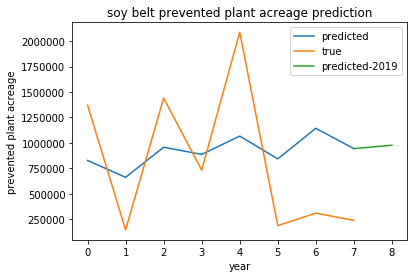

simple linear model taking inputs from 2019-04-08 to 2019-04-29:
('county-level score:', 0.0185158849357826)


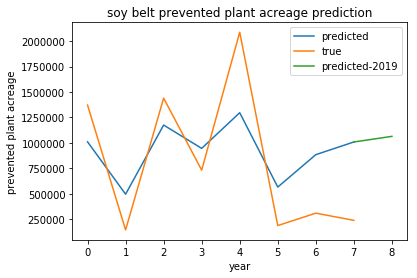

simple linear model taking inputs from 2019-04-08 to 2019-05-06:
('county-level score:', 0.01928406965113627)


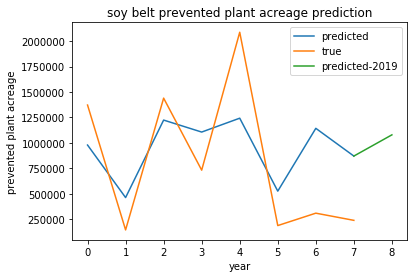

simple linear model taking inputs from 2019-04-08 to 2019-05-13:
('county-level score:', 0.02650738810589859)


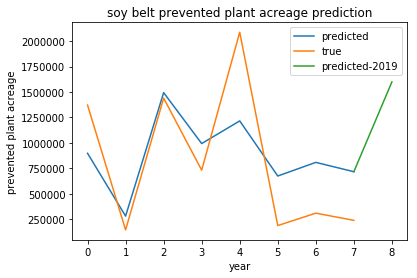

simple linear model taking inputs from 2019-04-08 to 2019-05-20:
('county-level score:', 0.03685763015828958)


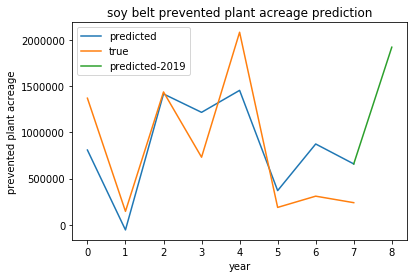

simple linear model taking inputs from 2019-04-08 to 2019-05-27:
('county-level score:', 0.040179340630899896)


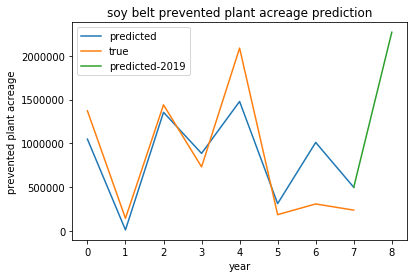

simple linear model taking inputs from 2019-04-08 to 2019-06-03:
('county-level score:', 0.04412409939360695)


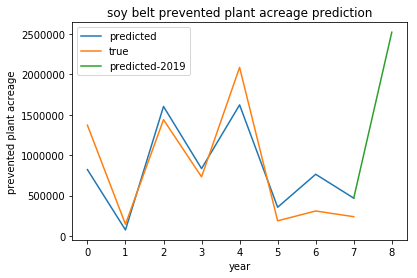

simple linear model taking inputs from 2019-04-08 to 2019-06-10:
('county-level score:', 0.04964871561574524)


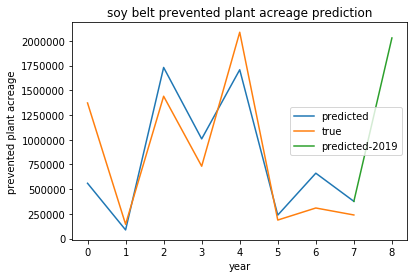

simple linear model taking inputs from 2019-04-08 to 2019-06-17:
('county-level score:', 0.05550740263736209)


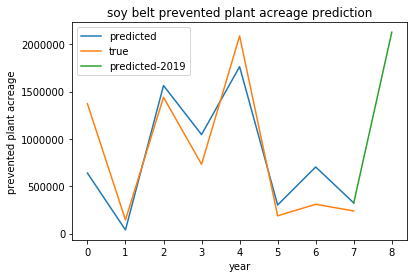

simple linear model taking inputs from 2019-04-08 to 2019-06-24:
('county-level score:', 0.07433487334672406)


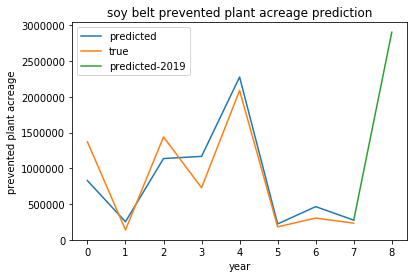

simple linear model taking inputs from 2019-04-08 to 2019-07-01:
('county-level score:', 0.07693479779259071)


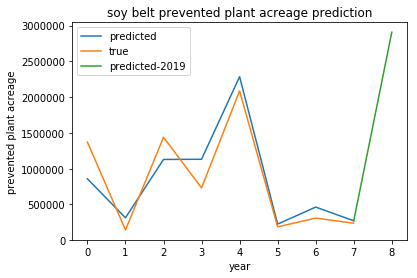

simple linear model taking inputs from 2019-04-08 to 2019-07-08:
('county-level score:', 0.07788019138193336)


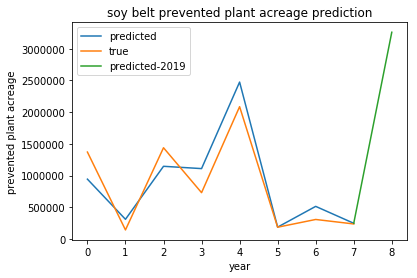

[976481.5530946585, 1064012.462761974, 1078903.5392858735, 1599034.6697694883, 1924922.1856465724, 2267983.1198345358, 2522732.3124566134, 2029444.036164605, 2126924.8459675484, 2897889.3674682956, 2906752.776247751, 3260309.021860515]


In [153]:
import sklearn.linear_model
from sklearn.model_selection import train_test_split

# the predictor
yearly_data_ratio = get_yearly_data_ratio('fsa_area_prevented_non_irrigated_' + crop)

# the feature idx we will use to get back to real-world numbers instead of a ratio
numerator_idx = features_list.index('fsa_area_prevented_non_irrigated_' + crop) 

y = np.reshape(yearly_data_ratio, -1)

# X_yearly has shape (county_idx, year, feature_idx) and is composed of features:
# deviation SMOS up to that week
# deviation TRMM up to that week
# crop progress up to that week

# week 14 is first week of april this year
# week 26 is last week of june this year
start_week = 14
start_date = datetime.datetime.strptime('2019-{}'.format(start_week*7), '%Y-%j').date()

curr_year_prediction_list = []

for week_offset in range(2,14):
    
    week_idx = start_week + week_offset
    end_date = datetime.datetime.strptime('2019-{}'.format(week_idx*7), '%Y-%j').date()
    
    print("simple linear model taking inputs from {} to {}:".format(start_date, end_date))
    X_yearly = np.zeros((num_counties, 9, week_offset*3 - lag_progress - lag_smos - lag_trmm))
    X_yearly[:,:,:] = np.nan # catch bugs
    
    county_idx = 0
    for idx, state_id in enumerate(state_ids.values()):
        X_yearly[county_idx:county_idx+len(county_ids[state_id]),:,0:week_offset - lag_progress] =\
            soy_belt_progress_weekly[idx,-9:,start_week:week_idx - lag_progress]
        county_idx += len(county_ids[state_id])

    X_yearly[:,:,week_offset - lag_progress:week_offset*2 - lag_progress - lag_trmm] =\
        np.array(soy_belt_weekly_year_trmm)[:,-9:,start_week:week_idx - lag_trmm]
    X_yearly[:,:,week_offset*2 - lag_progress - lag_trmm:week_offset*3 - lag_progress -\
             lag_trmm - lag_smos] = np.array(
        soy_belt_weekly_year)[:,-9:,start_week:week_idx - lag_smos]


    # Uncomment to weight by soy acreage ratio in that county
    # X_yearly[:,:,week_offset*2 - lag_progress - lag_trmm:week_offset*3 - lag_progress - lag_trmm - lag_smos] *= weight_soy[:, np.newaxis, np.newaxis]
    # X_yearly[:,:,week_offset - lag_progress:week_offset*2 - lag_progress - lag_trmm] *= weight_soy[:, np.newaxis, np.newaxis]
    
    # X_yearly conssists of:
    # 0:week_offset columns for smos
    # week_offset:week_offset*2 columns for trmm
    # week_offset*2: weekoffset*3 columns for crop progress
    
    X_truncated = X_yearly[:, :-1, :]
    
    # fill in nans by mean
    nanids = np.where(np.isnan(X_truncated))
    X_truncated[nanids] = np.take(np.nanmean(X_truncated, axis=0), nanids[1])
    
    X = np.reshape(X_truncated, (-1, X_truncated.shape[2]))
    
    # for polynomial features do:
    # X = np.concatenate((X, X**2), axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    reg_linear = sklearn.linear_model.LinearRegression().fit(X_train,y_train)
    print("county-level score:", reg_linear.score(X_test,y_test))
    denominator_values_prediction = np.sum(yearly_data[:,:,denominator_idxs], axis=2)
    yearly_prevented_predictions = []

    for year in range(8, 0, -1):
        yearly_prevented_predictions.append(np.sum(
            reg_linear.predict(X_truncated[:, -year, :])*denominator_values_prediction[:, -year]))
    
    plt.plot(yearly_prevented_predictions, label="predicted")
    plt.plot(np.sum(yearly_data[:,-8:,numerator_idx], axis=0), label="true")
    
    X_pred = X_yearly[:, -1, :]
    if np.sum(np.isnan(X_pred).sum(axis=0)>100) == 0:
#     if not np.any(np.isnan(X_yearly[:, -1, :])):
        nanids = np.where(np.isnan(X_pred))
        X_pred[nanids] = np.take(np.nanmean(X_pred, axis=0), nanids[1])
        curr_year_prediction = reg_linear.predict(X_pred) * np.mean(
            denominator_values_prediction[:, -3:], axis=1)
        curr_year_sum = np.sum(curr_year_prediction)
        curr_year_prediction_list.append(curr_year_sum)
        plt.plot((7,8), (yearly_prevented_predictions[-1], curr_year_sum), label="predicted-2019")
    
    plt.title("soy belt prevented plant acreage prediction")
    plt.xlabel("year")
    plt.ylabel("prevented plant acreage")
    plt.legend()
    plt.show()

print(curr_year_prediction_list)

### Ensemble Boosting Trees

In [154]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
"""Creating a dataframe with desired features and target: 
smos: smos_week_i represents smos (deviation) of week i
trmm: trmm_week_i represents trmm (deviation) of week i
progress: prog_week_i represents planting progress (state level broadcasted to county level) of week i  
ratio: prevented acreage as a fraction of prevented+failed+planted
absolute: prevented acreage
"""
smos_cols = ['smos_week_'+str(i) for i in range(start_week+1, start_week+14-lag_smos)]
trmm_cols = ['trmm_week_'+str(i) for i in range(start_week+1, start_week+14-lag_trmm)]
prog_cols = ['prog_week_'+str(i) for i in range(start_week+1, start_week+14-lag_prog)]
features = prog_cols + trmm_cols + smos_cols
df_latestyear = pd.DataFrame(X_yearly[:,-1,:], columns=features)
df = pd.DataFrame(X, columns=features)
df.loc[:, 'ratio'] = y
y_absolute = np.reshape(yearly_data[:,:,numerator_idx], (-1))
df.loc[:, 'planted'] = np.reshape(denominator_values_prediction, (-1))
df.loc[:, 'absolute'] = y_absolute

In [85]:
# Analyst recommended patch to move ILLINOIS over IOWA in latestyear
# For soy test both cases
iowa_state = client.lookup('regions', 13066)
illi_state = client.lookup("regions", 13064)
iowa_latlon = np.array((iowa_state.get("latitude"), iowa_state.get("longitude")))
illi_latlon = np.array((illi_state.get("latitude"), illi_state.get("longitude")))

delta_latlon = (iowa_latlon - illi_latlon)

In [155]:
"""Adding latitude and longitude as features
lat: latitude of the county
lon: longitude of the county
"""

import itertools
county_list = []
lat_list = []
lon_list = []
lat_list_patched = []
lon_list_patched = []
for state_id in state_ids.values():
    for county_id in county_ids[state_id]:
        county_list.append(county_id)
        county = client.lookup('regions', county_id)  
        lat_list.append(county.get('latitude'))
        lon_list.append(county.get('longitude'))
        
        lat_list_patched.append(county.get('latitude'))
        lon_list_patched.append(county.get('longitude'))
        
#         unccomment the following for placing illinois on top of iowa
#         if state_id == 13064:
#             lat_list_patched[-1] += delta_latlon[0]
#             lon_list_patched[-1] += delta_latlon[1]

df.loc[:, 'region_id'] = list(itertools.chain.from_iterable((itertools.repeat(i, 8) for i in county_list)))
df.loc[:, 'lat'] = list(itertools.chain.from_iterable((itertools.repeat(i, 8) for i in lat_list)))
df.loc[:, 'lon'] = list(itertools.chain.from_iterable((itertools.repeat(i, 8) for i in lon_list)))
df_latestyear.loc[:, 'lat'] = lat_list_patched
df_latestyear.loc[:, 'lon'] = lon_list_patched
df_latestyear.loc[:, 'region_id'] = county_list
df_latestyear.loc[:, 'year'] = 2019

In [156]:
df.loc[:, 'year'] = range(2011, 2019)*len(county_list)

In [157]:
target = 'absolute'

model taking inputs from 2019-04-08 to 2019-04-22:


/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in divide


county-level score for ratio r2: -43684.8806284, mse: 143.1878627
county-level score for absolute r2: 0.0547158684202, mse: 5521186.05589
belt-level mean absolute deviation is: 702012.364375


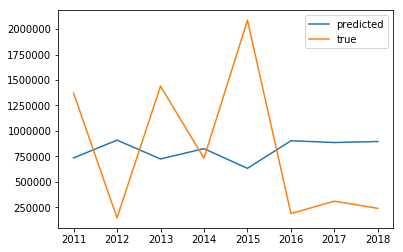

model taking inputs from 2019-04-08 to 2019-04-29:
county-level score for ratio r2: -6560377.65888, mse: 21502.7506635
county-level score for absolute r2: 0.0466262854746, mse: 5568435.43951
belt-level mean absolute deviation is: 492525.884641


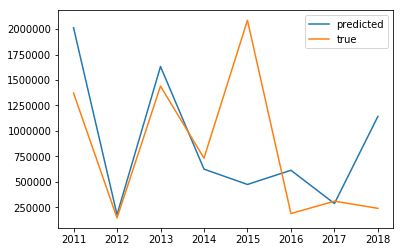

model taking inputs from 2019-04-08 to 2019-05-06:
county-level score for ratio r2: -226915.993052, mse: 743.758825006
county-level score for absolute r2: 0.140681072288, mse: 5019083.17589
belt-level mean absolute deviation is: 479698.320937


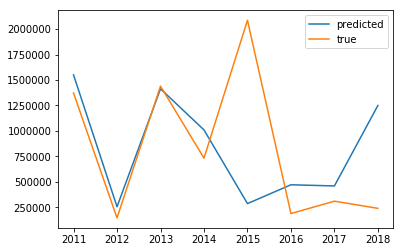

model taking inputs from 2019-04-08 to 2019-05-13:
county-level score for ratio r2: -1136054.64148, mse: 3723.61451509
county-level score for absolute r2: -0.442628432638, mse: 8426059.1287
belt-level mean absolute deviation is: 1038368.65495


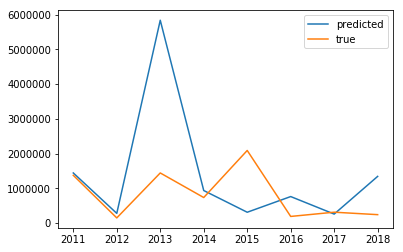

model taking inputs from 2019-04-08 to 2019-05-20:
county-level score for ratio r2: -118792.346572, mse: 389.365285852
county-level score for absolute r2: -0.505827996142, mse: 8795193.16692
belt-level mean absolute deviation is: 1066658.79125


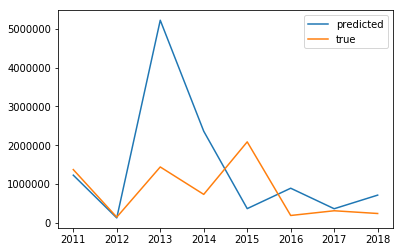

model taking inputs from 2019-04-08 to 2019-05-27:
county-level score for ratio r2: -264615.830706, mse: 867.326419388
county-level score for absolute r2: -0.504952212607, mse: 8790077.91778
belt-level mean absolute deviation is: 1023250.67555


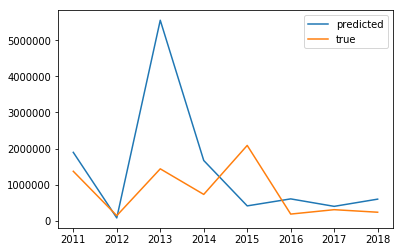

model taking inputs from 2019-04-08 to 2019-06-03:
county-level score for ratio r2: -368226.858087, mse: 1206.92908619
county-level score for absolute r2: -0.496122913651, mse: 8738508.02398
belt-level mean absolute deviation is: 964690.948008


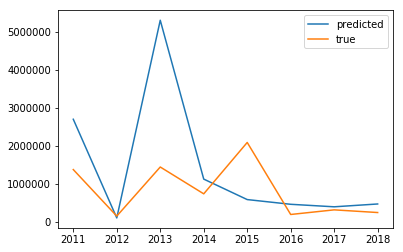

model taking inputs from 2019-04-08 to 2019-06-10:
county-level score for ratio r2: -1313898.17023, mse: 4306.52676064
county-level score for absolute r2: -0.19673147708, mse: 6989831.86448
belt-level mean absolute deviation is: 779186.872305


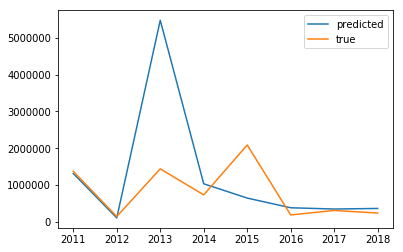

model taking inputs from 2019-04-08 to 2019-06-17:
county-level score for ratio r2: -2069583.4406, mse: 6783.41304934
county-level score for absolute r2: -0.150339528528, mse: 6718867.21915
belt-level mean absolute deviation is: 804927.259531


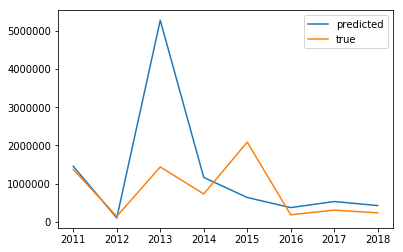

model taking inputs from 2019-04-08 to 2019-06-24:
county-level score for ratio r2: -803672.44107, mse: 2634.17563479
county-level score for absolute r2: -0.042905656006, mse: 6091370.80925
belt-level mean absolute deviation is: 682483.248789


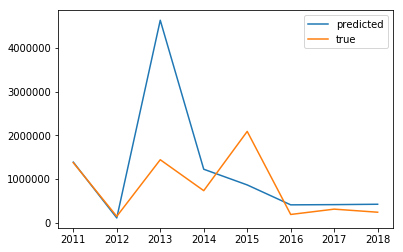

model taking inputs from 2019-04-08 to 2019-07-01:
county-level score for ratio r2: -1046587.83976, mse: 3430.37194022
county-level score for absolute r2: -0.0889536299237, mse: 6360326.37827
belt-level mean absolute deviation is: 687006.10082


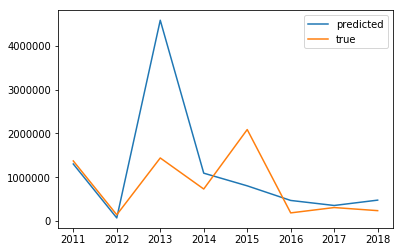

model taking inputs from 2019-04-08 to 2019-07-08:
county-level score for ratio r2: -1406906.50686, mse: 4611.37731519
county-level score for absolute r2: -0.0909649838252, mse: 6372074.23137
belt-level mean absolute deviation is: 694512.738516


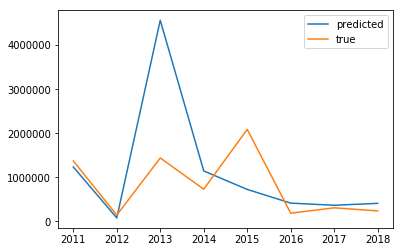

[]


In [89]:
"""
Out of sample testing (leave one year out)
"""
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

start_date = datetime.datetime.strptime('2019-{}'.format(start_week*7), '%Y-%j').date()

metrics = ['belt_mae', 'county_ratio_r2', 'county_ratio_mse', 'county_absolute_r2', 'county_absolute_mse']
df_metrics = pd.DataFrame(columns=metrics)

curr_year_prediction_list = []

belt_mae_l = []
county_ratio_r2= []
county_ratio_mse = []
county_absolute_r2 = []
county_absolute_mse = []

for week_offset in range(2,14):
    
    week_idx = start_week + week_offset
    end_date = datetime.datetime.strptime('2019-{}'.format(week_idx*7), '%Y-%j').date()
    
    print("model taking inputs from {} to {}:".format(start_date, end_date))

    features_week = prog_cols[2:week_offset-lag_prog] + smos_cols[2:week_offset-lag_smos] +\
        trmm_cols[2:week_offset-lag_trmm]
    features_week += ['lat', 'lon', 'aws0_5', 'soc0_5', 'nccpics']
    denominator_values_prediction = np.sum(yearly_data[:,:,denominator_idxs], axis=2)
    yearly_prevented_predictions = []    
    df.loc[:, 'pred_ratio'] = 0
    df.loc[:, 'pred_absolute'] = 0

    for year in range(8):
        # training on rows whose year column != year
        # predicting and scoring on rows whose year column == year
        test_year = 2011 + year
        reg = XGBRegressor()
        
        # uncomment to only train on counties with any corn/soy planted
        #df = df.loc[df.planted > 0.0]
        
        X_train = df.loc[df.year!=test_year, features_week]
        X_test = df.loc[df.year==test_year, features_week]
        y_train = df.loc[df.year!=test_year, target]
        y_test = df.loc[df.year==test_year, target]
        reg.fit(X_train,y_train)
        df.loc[df.year==test_year, 'pred_'+target] = reg.predict(X_test)
        if target == 'ratio':
            df.loc[df.year==test_year, 'pred_absolute'] =\
                reg.predict(X_test) * denominator_values_prediction[:, -year]
            yearly_prevented_predictions.append(
                np.sum(reg.predict(X_test)*denominator_values_prediction[:, -year]))
        else:
            df.loc[df.year==test_year, 'pred_ratio'] =\
                reg.predict(X_test) / denominator_values_prediction[:, -year]
            yearly_prevented_predictions.append(np.sum(reg.predict(X_test)))
    
    # plotting belt level aggregation
    ratio_r2 = r2_score(df['ratio'], df['pred_ratio'])
    county_ratio_r2.append(ratio_r2)
    ratio_mse = mean_squared_error(df['ratio'], df['pred_ratio'])
    county_ratio_mse.append(ratio_mse)
    print("county-level score for ratio r2: {}, mse: {}".format(ratio_r2, ratio_mse))
    absolute_r2 = r2_score(df['absolute'], df['pred_absolute'])
    county_absolute_r2.append(absolute_r2)
    absolute_mse = mean_squared_error(df['absolute'], df['pred_absolute'])
    county_absolute_mse.append(absolute_mse)
    print("county-level score for absolute r2: {}, mse: {}".format(absolute_r2, absolute_mse))
    belt_mae = mean_absolute_error(np.sum(yearly_data[:,-8:,numerator_idx], axis=0), yearly_prevented_predictions)
    belt_mae_l.append(belt_mae)
    print("belt-level mean absolute deviation is: {}".format(belt_mae))
    df_metrics.loc[week_idx] = [belt_mae, ratio_r2, ratio_mse, absolute_r2, absolute_mse]

    plt.plot(yearly_prevented_predictions, label="predicted")
    plt.plot(np.sum(yearly_data[:,-8:,numerator_idx], axis=0), label="true")
    
    # make predictions for the first 9 weeks
    if not df_latestyear.loc[:, features_week].isnull().all().any():
        reg = XGBRegressor()
        reg.fit(df[features_week], df[target])
        curr_year_prediction = reg.predict(df_latestyear.loc[:, features_week]) 
        if target == 'ratio':
            curr_year_prediction = curr_year_prediction *\
                np.mean(denominator_values_prediction[:, -3:], axis=1) # county_acreage_3yr_avg_list * 2.47105
        curr_year_sum = np.sum(curr_year_prediction)
        curr_year_prediction_list.append(curr_year_sum)
        plt.plot((7,8), (yearly_prevented_predictions[-1], curr_year_sum), label="predicted-2019")
    
    plt.xticks(range(8), range(2011, 2019))
    plt.legend()
    plt.show()
    
print(curr_year_prediction_list)

In [97]:
results_df = pd.DataFrame([["prediction_2019"] + curr_year_prediction_list,
                           ["belt_mae_l"] + belt_mae_l, 
                           ["county_ratio_r2"] + county_ratio_r2, 
                           ["county_ratio_mse"] + county_ratio_mse, 
                           ["county_absolute_r2"] + county_absolute_r2, 
                           ["county_absolute_mse"] + county_absolute_mse])

results_df.columns = ["metric"] + ["week {}".format(i) for i in range(13)]
results_df.set_index("metric")
pd.set_option('display.float_format', lambda x: '%.3f' % x)
display(results_df)

ValueError: Length mismatch: Expected axis has 13 elements, new values have 14 elements

### Add corn progress

In [158]:
# add historical area prevented, non irrigated, yellow corn
df_corn = pd.DataFrame()
for state_id in state_ids.values():
    df_add = pd.DataFrame(client.get_data_points(**{
        'metric_id': 15850172,  # area prevented, non irrig
        'item_id': 11645, # yellow corn, for grain
        'region_id': state_id, 
        'source_id': 100, # FSA
        'frequency_id': 9, # yearly
    }))
    df_corn = pd.concat([df_corn, df_add])
df_corn.loc[:, 'year'] = pd.to_datetime(df_corn['start_date']).apply(lambda x: x.year)
df = df.merge(df_corn[['year', 'region_id', 'value']].rename(
    columns={'value': 'prevented_absolute_corn'}), on=['year', 'region_id'], how='left')
df.loc[:, 'prevented_absolute_corn'] = df.loc[:, 'prevented_absolute_corn'].fillna(0)

In [99]:
# add corn progress
# Corn, planted - Crop Progress, % of Total - US Soybean Belt States (USDA NASS Crops)
df_corn_progress = pd.DataFrame(client.get_data_points(**{
    'metric_id': 2860042, # planting progress
    'item_id': 3231, # corn, planted
    'region_id': 100000101, # soy belt
    'source_id': 25, # NASS
    'frequency_id': 2, # weekly
}))
df_corn_progress.loc[:, 'year'] = pd.to_datetime(
    df_corn_progress['start_date']).apply(lambda x: x.year)
df_corn_progress.loc[:, 'week_idx'] = pd.to_datetime(
    df_corn_progress['start_date']).apply(lambda x: int(x.strftime('%j'))) // 7

In [159]:
# pivot corn progress 
end_week = 28
df_corn_progress_pivot = df_corn_progress[(df_corn_progress.year>=start_year) &
                 (df_corn_progress.week_idx>start_week)].pivot_table(
    index=['year', 'region_id'], columns='week_idx', values='value').reset_index().rename(
    columns={i: 'prog_week_corn_'+str(i) for i in range(start_week, end_week)})
prog_cols_corn = ['prog_week_corn_'+str(i) for i in range(start_week+1, 26)]

In [101]:
# county to state mapping table
df_county_state = pd.DataFrame()
for state_id, county_id_list in county_ids.iteritems():
    df_add = pd.DataFrame(county_id_list, columns=['county_id'])
    df_add.loc[:, 'state_id'] = state_id
    df_county_state = pd.concat([df_county_state, df_add])

In [160]:
# merge corn progress to training data
df = df.merge(df_county_state, left_on='region_id', right_on='county_id', how='left')
df = df.merge(df_corn_progress_pivot[['year', 'region_id']+prog_cols_corn].rename(
    columns={'region_id': 'state_id'}), on=['year', 'state_id'], how='left')
df.loc[:, prog_cols_corn] = df[prog_cols_corn].fillna(method='bfill', axis=1).fillna(method='ffill', axis=1)
df.loc[:, prog_cols_corn] = df[prog_cols_corn].fillna(df[prog_cols_corn].mean())

In [161]:
# merge corn progress to testing data
df_latestyear = df_latestyear.merge(
    df_county_state, left_on='region_id', right_on='county_id', how='left')
df_latestyear = df_latestyear.merge(df_corn_progress_pivot[['year', 'region_id']+prog_cols_corn].rename(
    columns={'region_id': 'state_id'}), on=['year', 'state_id'], how='left')

### Add soil properties from gSSURGO

In [104]:
soil_properties = {
    # Soil water storage from 0 to 5 cm deep - Availability in soil (length) - US Soybean Belt States (gSSURGO)
    'aws0_5': {
        'metric_id': 15530031,
        'item_id': 8808, 
        'source_id': 87, 
        'frequency_id': 15, # static
    },
    # Soil organic carbon stock from 0 to 5 cm deep - Availability in soil (mass/area) - US Soybean Belt States (gSSURGO)
    'soc0_5': {
        'metric_id': 15530037, 
        'item_id': 8819, 
        'source_id': 87, 
        'frequency_id': 15, # static
    },
    # Corn and soybeans - Crop productivity index - US Soybean Belt States (gSSURGO)
    'nccpics':{
        'metric_id': 15540029, 
        'item_id': 8830, 
        'source_id': 87, 
        'frequency_id': 15, # static
    },
}

df_soil_list = []
for soil_prop, entities in soil_properties.iteritems():
    df_soil = pd.DataFrame()
    for county in county_list:
        entities['region_id'] = county
        df_add = pd.DataFrame(client.get_data_points(**entities))[['region_id', 'value']]
        df_soil = pd.concat([df_soil, df_add])
    df_soil_list.append(df_soil.rename(columns={'value': soil_prop}))
df_soil = reduce(lambda x, y: pd.merge(x, y, on='region_id'), df_soil_list)

In [162]:
# merge soil properties to training and testing data
df = df.merge(df_soil, on='region_id', how='left')
df_latestyear = df_latestyear.merge(df_soil, on='region_id', how='left')

### Integrate corn prevented plant predictions to soybeans prevented plant model

model 16 taking inputs from 2019-04-08 to 2019-04-22:
county-level score for ratio r2: -423138.318196, mse: 1386.91068431
county-level score for absolute r2: -0.027924699918, mse: 6003870.50845
belt-level mean absolute deviation is: 780427.375471


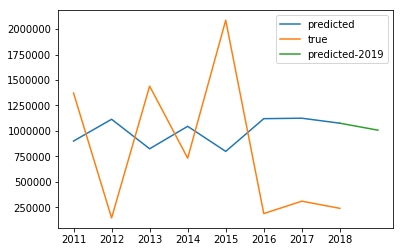

model 17 taking inputs from 2019-04-08 to 2019-04-29:
county-level score for ratio r2: -3042210.45277, mse: 9971.36258988
county-level score for absolute r2: -0.061802659459, mse: 6201743.83729
belt-level mean absolute deviation is: 702682.507662


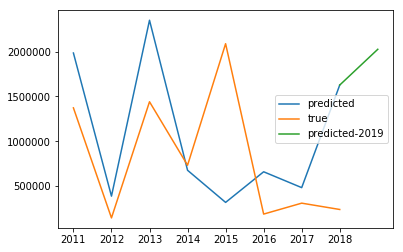

model 18 taking inputs from 2019-04-08 to 2019-05-06:
county-level score for ratio r2: -2107273.12969, mse: 6906.94738011
county-level score for absolute r2: 0.0501147744823, mse: 5548059.98178
belt-level mean absolute deviation is: 650852.730554


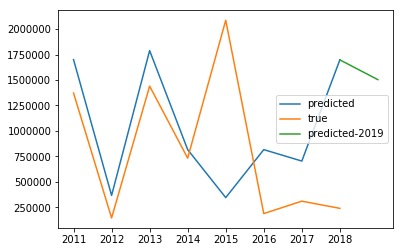

model 19 taking inputs from 2019-04-08 to 2019-05-13:
county-level score for ratio r2: -2291744.16157, mse: 7511.58238812
county-level score for absolute r2: 0.0698655923911, mse: 5432700.02091
belt-level mean absolute deviation is: 672344.315227


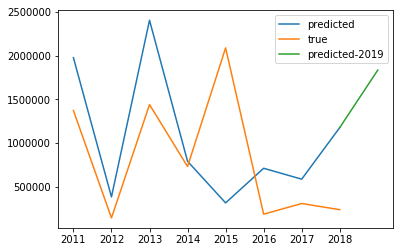

model 20 taking inputs from 2019-04-08 to 2019-05-20:
county-level score for ratio r2: -871716.585546, mse: 2857.20182716
county-level score for absolute r2: 0.072523032276, mse: 5417178.52896
belt-level mean absolute deviation is: 521324.384992


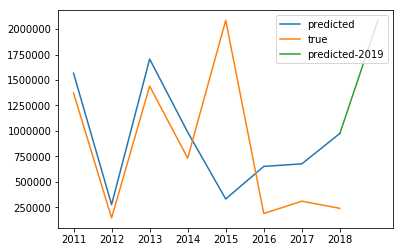

model 21 taking inputs from 2019-04-08 to 2019-05-27:
county-level score for ratio r2: -3311455.66289, mse: 10853.8593056
county-level score for absolute r2: -0.259640371131, mse: 7357268.16963
belt-level mean absolute deviation is: 630064.845775


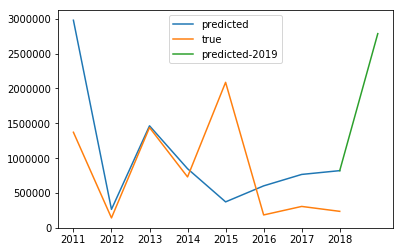

model 22 taking inputs from 2019-04-08 to 2019-06-03:
county-level score for ratio r2: -3801209.95736, mse: 12459.1118418
county-level score for absolute r2: -0.299912325819, mse: 7592487.34579
belt-level mean absolute deviation is: 586558.199915


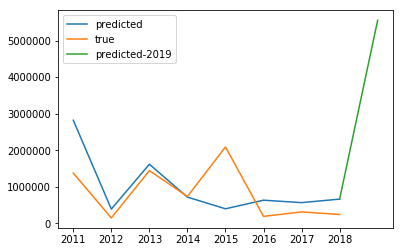

model 23 taking inputs from 2019-04-08 to 2019-06-10:
county-level score for ratio r2: -4482139.20288, mse: 14690.972615
county-level score for absolute r2: 0.107961731176, mse: 5210189.28237
belt-level mean absolute deviation is: 493491.105869


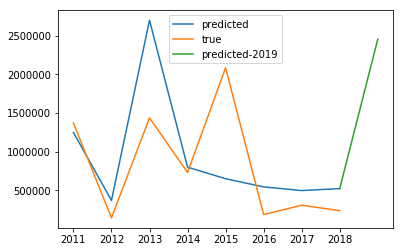

model 24 taking inputs from 2019-04-08 to 2019-06-17:
county-level score for ratio r2: -2479488.07045, mse: 8126.94480413
county-level score for absolute r2: 0.105473488099, mse: 5224722.53489
belt-level mean absolute deviation is: 577626.044328


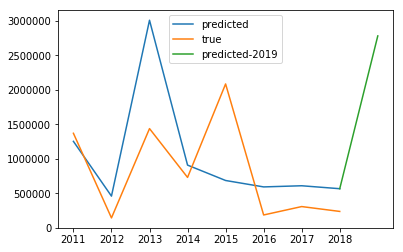

model 25 taking inputs from 2019-04-08 to 2019-06-24:
county-level score for ratio r2: -7555004.61743, mse: 24762.8087493
county-level score for absolute r2: 0.184096196878, mse: 4765505.47106
belt-level mean absolute deviation is: 377102.939991


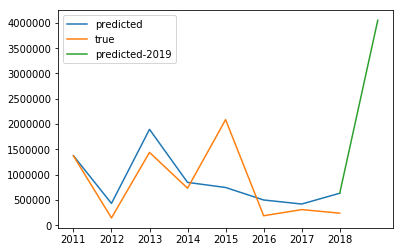

model 26 taking inputs from 2019-04-08 to 2019-07-01:
county-level score for ratio r2: -5767923.052, mse: 18905.3466553
county-level score for absolute r2: 0.199109348678, mse: 4677817.12255
belt-level mean absolute deviation is: 340651.930936


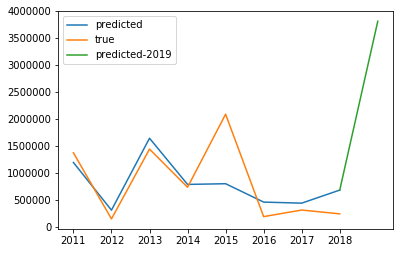

model 27 taking inputs from 2019-04-08 to 2019-07-08:
county-level score for ratio r2: -5296958.0627, mse: 17361.6792448
county-level score for absolute r2: 0.194998390188, mse: 4701828.2806
belt-level mean absolute deviation is: 395115.617698


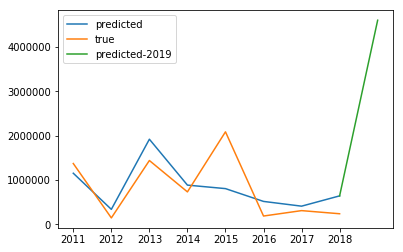

[1006955.4, 2024846.0, 1503146.5, 1833830.6, 2085596.4, 2784789.5, 5557813.0, 2456542.5, 2783445.0, 4052035.5, 3812341.5, 4604575.0]


In [163]:
"""
Out of sample testing (leave one year out)
"""
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

target = 'absolute'
start_date = datetime.datetime.strptime('2019-{}'.format(start_week*7), '%Y-%j').date()

metrics = ['belt_mae', 'county_ratio_r2', 'county_ratio_mse', 'county_absolute_r2', 'county_absolute_mse']
df_metrics = pd.DataFrame(columns=metrics)

curr_year_prediction_list = []

belt_mae_l = []
county_ratio_r2= []
county_ratio_mse = []
county_absolute_r2 = []
county_absolute_mse = []

for week_offset in range(2,14):
    
    week_idx = start_week + week_offset
    end_date = datetime.datetime.strptime('2019-{}'.format(week_idx*7), '%Y-%j').date()
    
    print("model {} taking inputs from {} to {}:".format(week_idx, start_date, end_date))

    features_week_soy = prog_cols[2:week_offset-lag_prog] +\
        smos_cols[2:week_offset-lag_smos] + trmm_cols[2:week_offset-lag_trmm]
    features_week_soy += ['lat', 'lon', 'aws0_5', 'soc0_5', 'nccpics']
    
    features_week_corn = prog_cols_corn[2:min(23, week_offset-lag_prog)]+\
        smos_cols[2:min(23, week_offset-lag_smos)] + trmm_cols[2:min(23, week_offset-lag_trmm)]
    features_week_corn += ['lat', 'lon']
    
    features_week = list(set(features_week_soy).union(set(features_week_corn)))
    denominator_values_prediction = np.sum(yearly_data[:,:,denominator_idxs], axis=2)
    yearly_prevented_predictions = [] 
    
    # uncomment to only train on counties with any corn/soy planted
    #df = df.loc[df.planted > 0.0, :]
    df.loc[:, 'pred_ratio'] = 0
    df.loc[:, 'pred_absolute'] = 0

    # corn model train and out of sample prediction
    reg_corn = XGBRegressor()
    for test_year in range(2011, 2019):
        # training on rows whose year column != year
        # predicting and scoring on rows whose year column == year
        
        train = df.loc[df.year!=test_year, :]
        test = df.loc[df.year==test_year, :]
        
        reg_corn.fit(train[features_week_corn], train['prevented_absolute_corn'])
        df.loc[df.year==test_year, 'pred_absolute_corn'] = reg_corn.predict(
            test[features_week_corn])
    reg_corn.fit(df[features_week_corn], df['prevented_absolute_corn'])    
    df_latestyear.loc[:, 'pred_absolute_corn'] = reg_corn.predict(
        df_latestyear[features_week_corn])
        
    # soy model train and out of sample prediction
    reg = XGBRegressor()
    for test_year in range(2011, 2019):
        
        train = df.loc[df.year!=test_year, :]
        test = df.loc[df.year==test_year, :]
        
        reg.fit(train[features_week_soy + ['prevented_absolute_corn']], train[target])
        df.loc[df.year==test_year, 'pred_'+target] = reg.predict(
            test[features_week_soy + ['pred_absolute_corn']].rename(
                columns={'pred_absolute_corn': 'prevented_absolute_corn'})
        )
        
        if target == 'ratio':
            df.loc[df.year==test_year, 'pred_absolute'] =\
                df.loc[df.year==test_year, 'pred_'+target] *\
                    denominator_values_prediction[:, 2011-test_year]
        else:
            df.loc[df.year==test_year, 'pred_ratio'] =\
                df.loc[df.year==test_year, 'pred_'+target] /\
                denominator_values_prediction[:, 2011-test_year]
        yearly_prevented_predictions.append(
            np.sum(df.loc[df.year==test_year, 'pred_absolute']))
    
    # plotting belt level aggregation
    df.loc[:, 'pred_ratio'] = df['pred_ratio'].fillna(0)
    ratio_r2 = r2_score(df['ratio'], df['pred_ratio'])
    county_ratio_r2.append(ratio_r2)
    ratio_mse = mean_squared_error(df['ratio'], df['pred_ratio'])
    county_ratio_mse.append(ratio_mse)
    print("county-level score for ratio r2: {}, mse: {}".format(ratio_r2, ratio_mse))
    absolute_r2 = r2_score(df['absolute'], df['pred_absolute'])
    county_absolute_r2.append(absolute_r2)
    absolute_mse = mean_squared_error(df['absolute'], df['pred_absolute'])
    county_absolute_mse.append(absolute_mse)
    print("county-level score for absolute r2: {}, mse: {}".format(absolute_r2, absolute_mse))
    belt_mae = mean_absolute_error(np.sum(yearly_data[:,-8:,numerator_idx], axis=0), yearly_prevented_predictions)
    belt_mae_l.append(belt_mae)
    print("belt-level mean absolute deviation is: {}".format(belt_mae))
    df_metrics.loc[week_idx] = [belt_mae, ratio_r2, ratio_mse, absolute_r2, absolute_mse]

    plt.plot(yearly_prevented_predictions, label="predicted")
    plt.plot(np.sum(yearly_data[:,-8:,numerator_idx], axis=0), label="true")
    
    # make predictions for the first 9 weeks
    if not df_latestyear.loc[:, features_week_soy].isnull().all().any():
    #if not np.any(np.isnan(df_latestyear.loc[:, features_week])):
        reg.fit(df.loc[:, features_week_soy+['prevented_absolute_corn']], df.loc[:, target])
        curr_year_prediction = reg.predict(
            df_latestyear[features_week_soy+['pred_absolute_corn']].rename(
                columns={'pred_absolute_corn': 'prevented_absolute_corn'}
            ).fillna(0)
        ) 
        if target == 'ratio':
            curr_year_prediction = curr_year_prediction *\
                np.mean(denominator_values_prediction[:, -3:], axis=1) # county_acreage_3yr_avg_list * 2.47105
        curr_year_sum = np.sum(curr_year_prediction)
        curr_year_prediction_list.append(curr_year_sum)
        plt.plot((7,8), (yearly_prevented_predictions[-1], curr_year_sum), label="predicted-2019")
    
    plt.xticks(range(8), range(2011, 2019))
    plt.legend()
    plt.show()
    
print(curr_year_prediction_list)

In [164]:
df_metrics

,belt_mae,county_ratio_r2,county_ratio_mse,county_absolute_r2,county_absolute_mse
16,780427.375,-423138.318,1386.911,-0.028,6003870.508
17,702682.508,-3042210.453,9971.363,-0.062,6201743.837
18,650852.731,-2107273.130,6906.947,0.050,5548059.982
19,672344.315,-2291744.162,7511.582,0.070,5432700.021
20,521324.385,-871716.586,2857.202,0.073,5417178.529
21,630064.846,-3311455.663,10853.859,-0.260,7357268.170
22,586558.200,-3801209.957,12459.112,-0.300,7592487.346
23,493491.106,-4482139.203,14690.973,0.108,5210189.282
24,577626.044,-2479488.070,8126.945,0.105,5224722.535
25,377102.940,-7555004.617,24762.809,0.184,4765505.471


In [165]:
curr_year_prediction_list

[1006955.4,
 2024846.0,
 1503146.5,
 1833830.6,
 2085596.4,
 2784789.5,
 5557813.0,
 2456542.5,
 2783445.0,
 4052035.5,
 3812341.5,
 4604575.0]

In [166]:
df_latestyear.loc[:, 'pred_absolute'] = curr_year_prediction
df_output = df_latestyear.groupby('state_id').sum()['pred_absolute'].reset_index()

In [167]:
df_output.merge(pd.DataFrame(zip(state_ids.keys(), state_ids.values())), 
                left_on='state_id', right_on=1)

,state_id,pred_absolute,0,1
0,13054,36855.484,Arkansas,13054
1,13064,648691.938,Illinois,13064
2,13065,561812.750,Indiana,13065
3,13066,85967.953,Iowa,13066
4,13067,251445.734,Kansas,13067
5,13068,205528.719,Kentucky,13068
6,13069,304308.688,Louisiana,13069
7,13073,441494.406,Michigan,13073
8,13074,74959.016,Minnesota,13074
9,13075,36382.367,Mississippi,13075


In [168]:
df_latestyear.loc[:, 'pred_absolute'] = df_latestyear['pred_absolute'].apply(lambda x: 0 if x<0 else x)

In [169]:
df_latestyear.to_csv('pp_soy_pred_07_09_2019.csv', index=False)

In [115]:
weeks = range(start_week+1, start_week+15)

# CHOROPLETHS

In [120]:
# Choropleth
import geopandas
import pandas as pd
import os
from shapely.geometry import shape

###
### GeoDataFrame has no simple support for loading a dict-of-json in python. Used workaround from here:
### https://stackoverflow.com/questions/45552955/loading-json-into-a-geodataframe
###

gdf = geopandas.GeoDataFrame()
county_areas = []

df_district = geopandas.GeoDataFrame([
    {
        'district_id': county_id, 
        'geometries': shape(client.get_geojson(county_id)['geometries'][0])
    } 
    for state_id in state_ids.values() for county_id in county_ids[state_id]
])

df_district = df_district.set_geometry("geometries")
df_district.crs = {'init' :'epsg:4326'}
df_district["area"] = df_district["geometries"].to_crs({'init': 'epsg:3395'}).map(lambda p: (p.area / 10**4))
county_area = df_district["area"].tolist()

df_state = geopandas.GeoDataFrame([
    {
        'district_id': state_id, 
        'geometries': shape(client.get_geojson(county_id)['geometries'][0])
    } 
    for state_id in state_ids.values()
])

df_state = df_state.set_geometry("geometries")
df_state.crs = {'init' :'epsg:4326'}

# for state_id in state_ids.values():
#     for county_id in county_ids[state_id]:
#         geojson = client.get_geojson(county_id)
#         geojson["geometries"] = shape(geojson["geometries"][0])
#         new_gdf = geopandas.GeoDataFrame(geojson).set_geometry("geometries")
#         new_gdf["district_id"] = county_id
#         # TODO: currently we ignore any secondary polygons that are separate from the main 
#         # county polygon. figure out how to add these to the same geodataframe
#         new_gdf.crs = {'init' :'epsg:4326'}
#         area_acres = new_gdf['geometries'].to_crs({'init': 'epsg:3395'})\
#             .map(lambda p: (p.area / 10**4))[0]
#         new_gdf["area"] = area_acres
#         county_areas.append(area_acres)
#         gdf = pd.concat([gdf, new_gdf.iloc[[0]]])
# df_district = gdf

# gdf = geopandas.GeoDataFrame()
# for state_id in state_ids.values():
#     geojson = client.get_geojson(state_id)
#     geojson["geometries"] = shape(geojson["geometries"][0])    
#     new_gdf = geopandas.GeoDataFrame(geojson).set_geometry("geometries")
#     # TODO: currently we ignore any secondary polygons that are separate from the main 
#     # county polygon. figure out how to add these to the same geodataframe
#     new_gdf.crs = {'init' :'epsg:4326'}
#     gdf = pd.concat([gdf, new_gdf])
# df_state = gdf

In [121]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
musen_colors = [
    (89, 3, 4),
    (139, 13, 25),
    (186, 24, 44),
    (227, 51, 77),
    (237, 132, 147), 
    (249, 214, 218),
    (255, 255, 255), 
    (209, 224, 230), 
    (121, 163, 182),
    (34, 100, 135),
    (11, 73, 109),
    (8, 56, 92),
    (3, 41, 69)
]
musen_colors_blue = [
    (255, 255, 255),
    (175, 213, 227), 
    (97, 171, 199), 
    (47, 129, 163),
    (24, 85, 118), 
    (2, 41, 70)
]
musen_colors = np.array(musen_colors)/256.0
musen_colors_blue = np.array(musen_colors_blue)/256.0

musen_cmap = LinearSegmentedColormap.from_list('musen_red_blue', musen_colors, N=len(musen_colors)*10)

musen_cmap_blue = LinearSegmentedColormap.from_list('musen_blue', musen_colors_blue, N=len(musen_colors_blue)*10)

## Plot county-level prevented planting predictions

21159.117


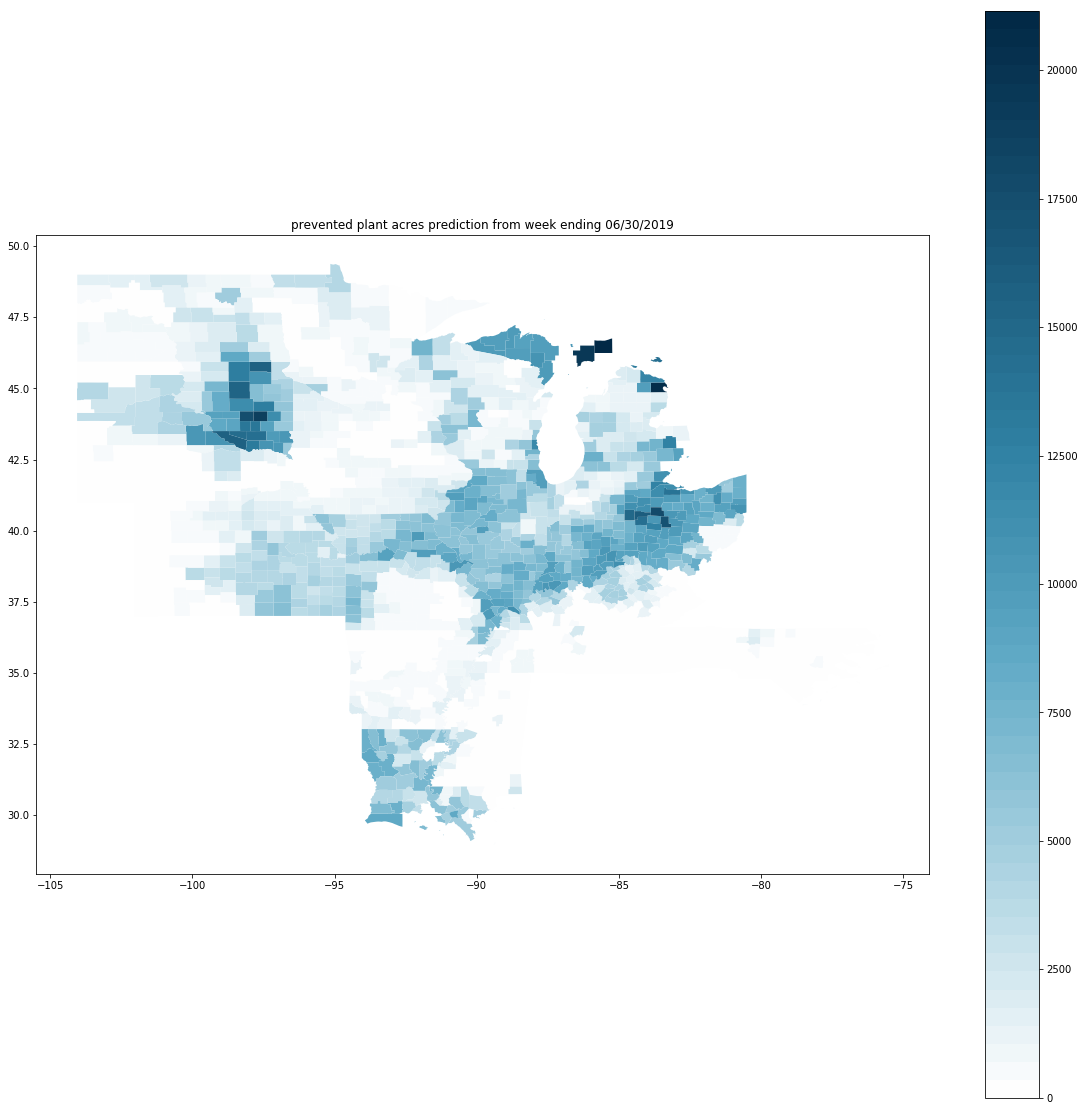

In [171]:
df_district["prediction"] = curr_year_prediction
df_district.loc[:, 'prediction'] = df_district['prediction'].apply(lambda x: 0 if x<0 else x)
fix, ax = plt.subplots(1, 1, figsize=(20,20))
df_district.plot("prediction", legend=True, axes=ax, cmap=musen_cmap_blue)
ax.set_title("prevented plant acres prediction from week ending 06/30/2019")
df_district.to_file("prevented_prediction_soy.shp")

## Plot county-level backtesting performance

In [124]:
week_offset = 8 # this is where you can checkout a different week
week_idx = start_week + week_offset
end_date = datetime.datetime.strptime('2019-{}'.format(week_idx*7), '%Y-%j').date()

print("model taking inputs from {} to {}:".format(start_date, end_date))

features_week = prog_cols[:week_offset-lag_prog] + smos_cols[:week_offset-lag_smos] + trmm_cols[:week_offset-lag_trmm]
features_week += ['lat', 'lon']

denominator_values_prediction = np.sum(yearly_data[:,:,denominator_idxs], axis=2)
yearly_prevented_predictions = []    
df.loc[:, 'pred_ratio'] = 0
df.loc[:, 'pred_absolute'] = 0
for year in range(week_offset):
    # training on rows whose year column != year
    # predicting and scoring on rows whose year column == year
    test_year = 2011 + year
    reg = XGBRegressor()
    X_train = df.loc[df.year!=test_year, features_week]
    y_train = df.loc[df.year!=test_year, 'ratio']
    X_test = df.loc[df.year==test_year, features_week]
    y_test = df.loc[df.year==test_year, 'ratio']
    reg.fit(X_train,y_train)
    df.loc[df.year==test_year, 'pred_ratio'] = reg.predict(X_test)
    df.loc[df.year==test_year, 'pred_absolute'] = reg.predict(X_test)*denominator_values_prediction[:, -year]
    print("county-level score of year {}:".format(test_year), reg.score(X_test,y_test))
    yearly_prevented_predictions.append(np.sum(reg.predict(X_test)*denominator_values_prediction[:, -year]))
df.loc[:, 'deviation'] = abs(df['pred_absolute'] - df['absolute'])
df_deviation = df.groupby('region_id').mean()['deviation'].reset_index()
df_deviation = df_district.merge(df_deviation, left_on='district_id', right_on='region_id')

model taking inputs from 2019-04-08 to 2019-06-03:
('county-level score of year 2011:', -0.6480622136429857)
('county-level score of year 2012:', -0.6529965564821509)
('county-level score of year 2013:', -0.21305569432733762)
('county-level score of year 2014:', 0.1638751193850455)
('county-level score of year 2015:', 0.020972622119025175)
('county-level score of year 2016:', 0.17073295749394335)
('county-level score of year 2017:', 0.14613793121209684)
('county-level score of year 2018:', -0.07247816600065438)


Text(0.5,1,'mean absolute deviation from backtesting week ending 06/02/2019')

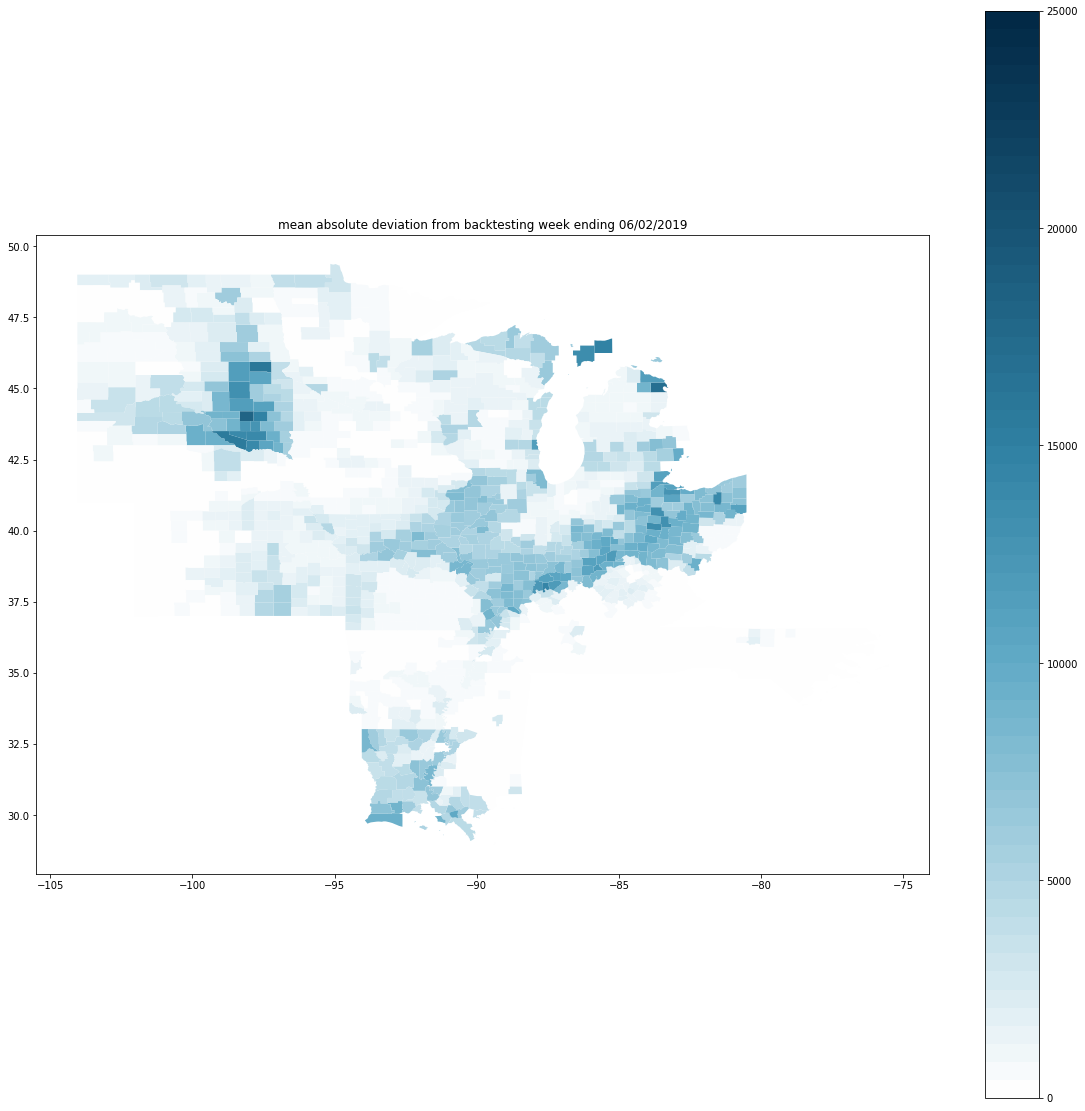

In [126]:
fix, ax = plt.subplots(1, 1, figsize=(20,20))
df_deviation.plot("prediction", legend=True, axes=ax, vmax=25000, cmap=musen_cmap_blue)
ax.set_title("mean absolute deviation from backtesting week ending {}".format(end_date))